In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [190]:
learning_rate=0.0001
train_size=0.8
bs=4
epochs=500

In [191]:
df=pd.read_csv('问题2-训练数据-归一化-回归.csv',index_col='time',parse_dates=True)
df['T']=100*df['year']+df['month']
# df=df.drop(columns='year')

In [192]:
# YCOLS=['100cm湿度(kg/m2)', '10cm湿度(kg/m2)', '40cm湿度(kg/m2)','200cm湿度(kg/m2)']
YCOLS=[ '40cm湿度(kg/m2)',]
XCOLS=['10cm湿度(kg/m2)',]
# XCOLS=['month', 'year']

X,Y=df[XCOLS].values,df[YCOLS].values

X_train,X_val,Y_train,Y_val = train_test_split(X,Y, train_size=train_size, shuffle=False)

In [193]:
X_train.shape,X_val.shape,Y_train.shape,Y_val.shape

((98, 1), (25, 1), (98, 1), (25, 1))

In [194]:
inputs = keras.layers.Input(shape=(X_train.shape[1], ))
x = keras.layers.Dense(128, activation='relu')(inputs)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation='relu')(x)
outputs = keras.layers.Dense(Y_train.shape[1])(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_69 (Dense)            (None, 128)               256       
                                                                 
 dense_70 (Dense)            (None, 16)                2064      
                                                                 
 dense_71 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


In [195]:
path_checkpoint = "problem2_regress_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=[es_callback, modelckpt_callback],
    batch_size=bs
)

Epoch 1/500
20/25 [=======================>......] - ETA: 0s - loss: 0.6965 
Epoch 1: val_loss improved from inf to 2.14461, saving model to problem2_regress_checkpoint.h5
25/25 [==============================] - 1s 13ms/step - loss: 0.6611 - val_loss: 2.1446
Epoch 2/500
24/25 [===========================>..] - ETA: 0s - loss: 0.6508
Epoch 2: val_loss improved from 2.14461 to 2.11476, saving model to problem2_regress_checkpoint.h5
25/25 [==============================] - 0s 8ms/step - loss: 0.6452 - val_loss: 2.1148
Epoch 3/500
15/25 [=================>............] - ETA: 0s - loss: 0.6585
Epoch 3: val_loss improved from 2.11476 to 2.08771, saving model to problem2_regress_checkpoint.h5
25/25 [==============================] - 0s 7ms/step - loss: 0.6344 - val_loss: 2.0877
Epoch 4/500
16/25 [==================>...........] - ETA: 0s - loss: 0.5810
Epoch 4: val_loss improved from 2.08771 to 2.05357, saving model to problem2_regress_checkpoint.h5
25/25 [==============================] - 

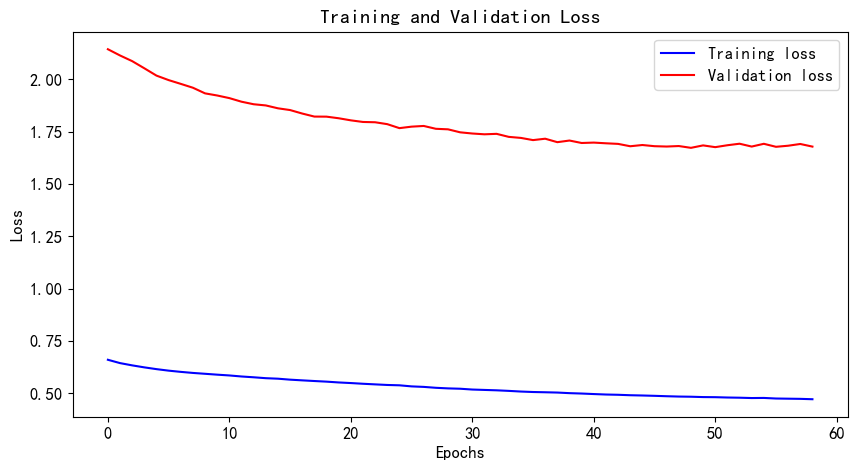

In [196]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [200]:
pred=model.predict(X)
df_pred=pd.DataFrame(data=pred, index=df.index, columns=YCOLS)
df_pred

4/4 [==============================] - 0s 4ms/step


,40cm湿度(kg/m2)
time,
2012-01-01,-0.476042
2012-02-01,-0.460566
2012-03-01,-0.456921
2012-04-01,-0.468253
2012-05-01,-0.452231
...,...
2021-11-01,-0.473091
2021-12-01,-0.462517
2022-01-01,-0.458679


In [201]:
px.line(df_pred)

In [199]:
px.line(df[YCOLS])